<a href="https://colab.research.google.com/github/truesrini/ExtensiveVisionAIProgramBatch2/blob/master/Session6%20Assignment/EVA4_Session6_Models_with_L1%2C_L2_Regularization%2C_BN%2CGBN%20V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 6 Assignment on Regularization and Normalization

For this solution I had taken Session 6's last submission. I had reduced the dropout further to 5% since we are adding more regularization techniques



1.   No L1 - No L2 - BN: Train - 0.9936 Tes t-0.9942 Comments:The Validation Accuracy Reached its maximum Much Earlier than the Testing Accuracy and hence less likely to improve further
2.   No L1 - No L2 - GBN: Train - 0.9931 Tes t-0.9947 Comments:It is better than Batch Normalization and Scope for Improvement is present as the validation accuracy and training accuracy both are improving
3. L1 - No L2 - BN: Train - 0.9917 Tes t-0.995 Comments:The Validation Accuracy Reached its maximum Much Earlier than the Testing Accuracy and hence less likely to improve further
4. L1 - No L2 - GBN: Train - 0.991 Tes t-0.9937 Comments:While the Accuracy is lower, slight scope for Improvement seems to be present, as the test accuracy max was reached only around 22nd Epoch
5. No L1 - L2 - BN: Train - 0.9934 Tes t-0.9943 Comments:This model is not heavily underfitting like others, but validation accuracy seems to stagnate around 99.43%
6. No L1 - L2 - GBN: Train - 0.993 Tes t-0.9934 Comments:the Training accuracy is higher than the validation accuracy in the last epoch hence, trained further this is likely to overfit
7. L1 - L2 - BN: Train - 0.9908 Tes t-0.9936 Comments:This is undefitting again probably because of a lot more regualarization than required
8. L1 - L2 - GBN: Train - 0.9909 Tes t-0.9946 Comments:This solution has potential as this is closer to the maximum and is underfitting a lot as well, so with more Epochs it might improve further




In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 28, output = 26, rf = 3, jump = 1
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(0.05)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 26, output = 24, rf = 5, jump = 1
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.dropout2 = nn.Dropout(0.05)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 24, output = 22, rf = 7, jump = 1
        self.batchnorm3 = nn.BatchNorm2d(8)
        self.dropout3 = nn.Dropout(0.05)
        self.pool1 = nn.AvgPool2d(2, 2)                #(k=2,p=0,s=2) input = 22, output = 11, rf = 8, jump = 1
        self.conv4 = nn.Conv2d(8, 16, 3, padding=0)    #(k=3,p=0,s=1) input = 11, output = 9, rf = 12, jump = 2
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.dropout4 = nn.Dropout(0.05)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=0)   #(k=3,p=0,s=1) input = 9, output = 7, rf = 16, jump = 2
        self.batchnorm5 = nn.BatchNorm2d(16)
        self.dropout5 = nn.Dropout(0.05)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=0)   #(k=3,p=0,s=1) input = 7, output = 5, rf = 20, jump = 2
        self.batchnorm6 = nn.BatchNorm2d(32)
        self.dropout6 = nn.Dropout(0.05)
        self.pool2 = nn.AvgPool2d(5, 5)                #(k=5,p=0,s=5) input = 5, output = 1, rf = 28, jump = 2
        self.conv8 = nn.Conv2d(32, 10, 1)


    def forward(self, x):
        x = self.pool1(self.dropout3(self.batchnorm3(F.relu(self.conv3(self.dropout2(self.batchnorm2(F.relu(self.conv2(self.dropout1(self.batchnorm1(F.relu(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout6(self.batchnorm6(F.relu(self.conv6(self.dropout5(self.batchnorm5(F.relu(self.conv5(self.dropout4(self.batchnorm4(F.relu(self.conv4(x)))))))))))))
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 28, output = 26, rf = 3, jump = 1
        self.batchnorm1 = GhostBatchNorm(num_features=8,num_splits=2)
        self.dropout1 = nn.Dropout(0.05)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 26, output = 24, rf = 5, jump = 1
        self.batchnorm2 = GhostBatchNorm(num_features=8,num_splits=2)
        self.dropout2 = nn.Dropout(0.05)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 24, output = 22, rf = 7, jump = 1
        self.batchnorm3 = GhostBatchNorm(num_features=8,num_splits=2)
        self.dropout3 = nn.Dropout(0.05)
        self.pool1 = nn.AvgPool2d(2, 2)                #(k=2,p=0,s=2) input = 22, output = 11, rf = 8, jump = 1
        self.conv4 = nn.Conv2d(8, 16, 3, padding=0)    #(k=3,p=0,s=1) input = 11, output = 9, rf = 12, jump = 2
        self.batchnorm4 = GhostBatchNorm(num_features=16,num_splits=2)
        self.dropout4 = nn.Dropout(0.05)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=0)   #(k=3,p=0,s=1) input = 9, output = 7, rf = 16, jump = 2
        self.batchnorm5 = GhostBatchNorm(num_features=16,num_splits=2)
        self.dropout5 = nn.Dropout(0.05)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=0)   #(k=3,p=0,s=1) input = 7, output = 5, rf = 20, jump = 2
        self.batchnorm6 = GhostBatchNorm(num_features=32,num_splits=2)
        self.dropout6 = nn.Dropout(0.05)
        self.pool2 = nn.AvgPool2d(5, 5)                #(k=5,p=0,s=5) input = 5, output = 1, rf = 28, jump = 2
        self.conv8 = nn.Conv2d(32, 10, 1)


    def forward(self, x):
        x = self.pool1(self.dropout3(self.batchnorm3(F.relu(self.conv3(self.dropout2(self.batchnorm2(F.relu(self.conv2(self.dropout1(self.batchnorm1(F.relu(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout6(self.batchnorm6(F.relu(self.conv6(self.dropout5(self.batchnorm5(F.relu(self.conv5(self.dropout4(self.batchnorm4(F.relu(self.conv4(x)))))))))))))
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
modelGBN = NetGBN().to(device)
summary(model, input_size=(1, 28, 28))
summary(modelGBN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
           Dropout-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             584
       BatchNorm2d-8            [-1, 8, 22, 22]              16
           Dropout-9            [-1, 8, 22, 22]               0
        AvgPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,168
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size =128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5.0,5.0),fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch=0, L1 = 0):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        reg_loss = 0
        for param in model.parameters():
          reg_loss += torch.sum(torch.abs(param))
        loss += L1 * reg_loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print('\nTrain set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

In [0]:
#Parameter list has list of parameters, each list has four parameters
#1st parameter is the name of the combination
#2nd parameter is l1 regularization
#3rd parameter is l2 regualization
#4th parameter is Batch Normalization required or not
#5th parameter is Ghost Batch Normalization is required or not

L1 = 0.0001
NO_L1 = 0.0
L2 = 0.0001
NO_L2 = 0.0

parameter_list = [["NO_L1L2_with_BN",NO_L1,NO_L2,"BN"],["NO_L1L2_with_GBN",NO_L1,NO_L2,"GBN"],["L1_with_BN",L1,NO_L2,"BN"],["L1_with_GBN",L1,NO_L2,"GBN"],
                  ["L2_with_BN",NO_L1,L2,"BN"],["L2_with_GBN",NO_L1,L2,"GBN"],["L1L2_with_BN",L1,L2,"BN"],["L1L2_with_GBN",L1,L2,"GBN"]]
df_loss = pd.DataFrame()
df_accuracy = pd.DataFrame()
i = 0

In [10]:
for parameter in parameter_list:
  print("PARAMETER IS ",parameter)
  Name = parameter[0]  
  L1 = parameter[1]
  L2 = parameter[2]
  BN_GBN = parameter[3]
  if BN_GBN == "BN":
    model = Net().to(device)
  else:
    model = NetGBN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=L2)
  scheduler = StepLR(optimizer,step_size=2,gamma=0.2)
  test_loss_list = []
  test_accuracy_list = []
  for epoch in range(1, 25):
      print("\n",Name," EPOC NUMBER IS :", epoch)
      train(model, device, train_loader, optimizer, epoch = epoch,L1 = L1)
      test_loss, test_accuracy = test(model, device, test_loader)
      test_loss_list.append(test_loss)
      test_accuracy_list.append(test_accuracy)
      if test_accuracy >= max(test_accuracy_list):
        torch.save(model.state_dict(),Name)
      print("\n--------------------------------------------------------------------------- \n")
  df_loss.insert(i,Name,test_loss_list)
  df_accuracy.insert(i,Name,test_accuracy_list)
  i += 1

  0%|          | 0/469 [00:00<?, ?it/s]

PARAMETER IS  ['NO_L1L2_with_BN', 0.0, 0.0, 'BN']

 NO_L1L2_with_BN  EPOC NUMBER IS : 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.14412683248519897 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]


Train set: Accuracy: 54493/60000 (90.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9819/10000 (98.19%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 2


loss=0.07260557264089584 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]


Train set: Accuracy: 58689/60000 (97.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9833/10000 (98.33%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 3


loss=0.065332792699337 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]


Train set: Accuracy: 58998/60000 (98.33%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9901/10000 (99.01%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 4


loss=0.030096745118498802 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]


Train set: Accuracy: 59179/60000 (98.63%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 5


loss=0.007344817277044058 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]


Train set: Accuracy: 59233/60000 (98.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 6


loss=0.008210008032619953 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]


Train set: Accuracy: 59288/60000 (98.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9918/10000 (99.18%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 7


loss=0.019836777821183205 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]


Train set: Accuracy: 59325/60000 (98.88%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 8


loss=0.023270487785339355 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]


Train set: Accuracy: 59405/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 9


loss=0.009117737412452698 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]


Train set: Accuracy: 59383/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 10


loss=0.053890395909547806 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]


Train set: Accuracy: 59426/60000 (99.04%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 11


loss=0.006447017192840576 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]


Train set: Accuracy: 59431/60000 (99.05%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 12


loss=0.02563493885099888 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]


Train set: Accuracy: 59470/60000 (99.12%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 13


loss=0.013215725310146809 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]


Train set: Accuracy: 59488/60000 (99.15%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 14


loss=0.0060050091706216335 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]


Train set: Accuracy: 59529/60000 (99.22%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 15


loss=0.015818268060684204 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]


Train set: Accuracy: 59513/60000 (99.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 16


loss=0.005999704357236624 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]


Train set: Accuracy: 59548/60000 (99.25%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 17


loss=0.04085441306233406 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]


Train set: Accuracy: 59518/60000 (99.20%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 18


loss=0.007642179727554321 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]


Train set: Accuracy: 59588/60000 (99.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 19


loss=0.03686951473355293 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]


Train set: Accuracy: 59564/60000 (99.27%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 20


loss=0.07163824141025543 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]


Train set: Accuracy: 59588/60000 (99.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 21


loss=0.02056623063981533 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]


Train set: Accuracy: 59597/60000 (99.33%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 22


loss=0.024342814460396767 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]


Train set: Accuracy: 59615/60000 (99.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 23


loss=0.053927768021821976 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]


Train set: Accuracy: 59596/60000 (99.33%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 24


loss=0.004278823733329773 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]


Train set: Accuracy: 59572/60000 (99.29%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['NO_L1L2_with_GBN', 0.0, 0.0, 'GBN']

 NO_L1L2_with_GBN  EPOC NUMBER IS : 1


loss=0.1968812197446823 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]


Train set: Accuracy: 54263/60000 (90.44%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9819/10000 (98.19%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 2


loss=0.08497917652130127 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


Train set: Accuracy: 58660/60000 (97.77%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9865/10000 (98.65%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 3


loss=0.11741475015878677 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Train set: Accuracy: 58921/60000 (98.20%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9881/10000 (98.81%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 4


loss=0.06609464436769485 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]


Train set: Accuracy: 59091/60000 (98.48%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9877/10000 (98.77%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 5


loss=0.03305418789386749 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]


Train set: Accuracy: 59169/60000 (98.61%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9911/10000 (99.11%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 6


loss=0.039053965359926224 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]


Train set: Accuracy: 59234/60000 (98.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 7


loss=0.016995111480355263 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]


Train set: Accuracy: 59275/60000 (98.79%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9908/10000 (99.08%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 8


loss=0.11145401746034622 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]


Train set: Accuracy: 59369/60000 (98.95%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 9


loss=0.007354786153882742 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]


Train set: Accuracy: 59382/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 10


loss=0.06426279991865158 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]


Train set: Accuracy: 59404/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 11


loss=0.04599687457084656 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


Train set: Accuracy: 59431/60000 (99.05%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 12


loss=0.0167376846075058 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]



Train set: Accuracy: 59427/60000 (99.05%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 13


loss=0.06158540025353432 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]


Train set: Accuracy: 59449/60000 (99.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 14


loss=0.02542291022837162 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]


Train set: Accuracy: 59454/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 15


loss=0.040745124220848083 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Train set: Accuracy: 59498/60000 (99.16%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 16


loss=0.09965922683477402 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]


Train set: Accuracy: 59517/60000 (99.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 17


loss=0.02863839827477932 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]


Train set: Accuracy: 59514/60000 (99.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 18


loss=0.007991060614585876 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]


Train set: Accuracy: 59529/60000 (99.22%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 19


loss=0.068058080971241 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]


Train set: Accuracy: 59535/60000 (99.22%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 20


loss=0.04948083683848381 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]


Train set: Accuracy: 59529/60000 (99.22%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 21


loss=0.01832501031458378 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]


Train set: Accuracy: 59566/60000 (99.28%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 22


loss=0.00973471999168396 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Train set: Accuracy: 59540/60000 (99.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 23


loss=0.03687866032123566 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]


Train set: Accuracy: 59583/60000 (99.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_GBN  EPOC NUMBER IS : 24


loss=0.013237416744232178 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Train set: Accuracy: 59553/60000 (99.25%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L1_with_BN', 0.0001, 0.0, 'BN']

 L1_with_BN  EPOC NUMBER IS : 1


loss=0.14164763689041138 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]


Train set: Accuracy: 54322/60000 (90.54%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9790/10000 (97.90%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 2


loss=0.11767102777957916 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]


Train set: Accuracy: 58750/60000 (97.92%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9901/10000 (99.01%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 3


loss=0.07754236459732056 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]


Train set: Accuracy: 59012/60000 (98.35%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9890/10000 (98.90%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 4


loss=0.12419148534536362 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]


Train set: Accuracy: 59112/60000 (98.52%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9877/10000 (98.77%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 5


loss=0.10474434494972229 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]


Train set: Accuracy: 59236/60000 (98.73%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 6


loss=0.09684422612190247 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]


Train set: Accuracy: 59260/60000 (98.77%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9903/10000 (99.03%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 7


loss=0.08209584653377533 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


Train set: Accuracy: 59336/60000 (98.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 8


loss=0.08426205813884735 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]


Train set: Accuracy: 59332/60000 (98.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 9


loss=0.1129414513707161 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]


Train set: Accuracy: 59375/60000 (98.96%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9911/10000 (99.11%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 10


loss=0.08388771116733551 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


Train set: Accuracy: 59406/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 11


loss=0.12037231773138046 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]


Train set: Accuracy: 59373/60000 (98.95%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 12


loss=0.11003588140010834 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]


Train set: Accuracy: 59387/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 13


loss=0.06220339611172676 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]


Train set: Accuracy: 59411/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 14


loss=0.06463789939880371 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Train set: Accuracy: 59433/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 15


loss=0.06256113946437836 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]


Train set: Accuracy: 59412/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 16


loss=0.07220267504453659 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]


Train set: Accuracy: 59413/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 17


loss=0.11325955390930176 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]


Train set: Accuracy: 59426/60000 (99.04%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9950/10000 (99.50%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 18


loss=0.09903249144554138 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]


Train set: Accuracy: 59473/60000 (99.12%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 19


loss=0.06059201434254646 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]


Train set: Accuracy: 59464/60000 (99.11%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 20


loss=0.10242734849452972 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


Train set: Accuracy: 59528/60000 (99.21%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 21


loss=0.10943953692913055 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]


Train set: Accuracy: 59436/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 22


loss=0.06941214203834534 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]


Train set: Accuracy: 59470/60000 (99.12%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 23


loss=0.10958817601203918 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


Train set: Accuracy: 59502/60000 (99.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 24


loss=0.10758622735738754 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]



Train set: Accuracy: 59477/60000 (99.13%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L1_with_GBN', 0.0001, 0.0, 'GBN']

 L1_with_GBN  EPOC NUMBER IS : 1


loss=0.1516532450914383 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]


Train set: Accuracy: 54165/60000 (90.28%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9843/10000 (98.43%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 2


loss=0.10981864482164383 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]


Train set: Accuracy: 58655/60000 (97.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9824/10000 (98.24%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 3


loss=0.11589013785123825 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]


Train set: Accuracy: 58943/60000 (98.24%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9874/10000 (98.74%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 4


loss=0.08474479615688324 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]


Train set: Accuracy: 59072/60000 (98.45%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 5


loss=0.11345100402832031 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]


Train set: Accuracy: 59101/60000 (98.50%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9880/10000 (98.80%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 6


loss=0.06421125680208206 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]


Train set: Accuracy: 59161/60000 (98.60%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9901/10000 (99.01%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 7


loss=0.109087735414505 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]


Train set: Accuracy: 59230/60000 (98.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 8


loss=0.06744053214788437 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]


Train set: Accuracy: 59206/60000 (98.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 9


loss=0.05750091001391411 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


Train set: Accuracy: 59283/60000 (98.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 10


loss=0.0986931324005127 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


Train set: Accuracy: 59253/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 11


loss=0.10741551965475082 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]


Train set: Accuracy: 59305/60000 (98.84%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 12


loss=0.07980392128229141 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]


Train set: Accuracy: 59314/60000 (98.86%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 13


loss=0.06571115553379059 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


Train set: Accuracy: 59324/60000 (98.87%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 14


loss=0.16980502009391785 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]


Train set: Accuracy: 59364/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 15


loss=0.1024727001786232 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


Train set: Accuracy: 59366/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 16


loss=0.08751767873764038 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]


Train set: Accuracy: 59382/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 17


loss=0.07879802584648132 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]


Train set: Accuracy: 59381/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 18


loss=0.11129561066627502 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]


Train set: Accuracy: 59364/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 19


loss=0.07604160904884338 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Train set: Accuracy: 59393/60000 (98.99%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9913/10000 (99.13%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 20


loss=0.05346745252609253 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]


Train set: Accuracy: 59404/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 21


loss=0.06400423496961594 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]


Train set: Accuracy: 59384/60000 (98.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 22


loss=0.08289475739002228 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


Train set: Accuracy: 59460/60000 (99.10%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 23


loss=0.10457807779312134 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]


Train set: Accuracy: 59391/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)


--------------------------------------------------------------------------- 


 L1_with_GBN  EPOC NUMBER IS : 24


loss=0.07980571687221527 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]


Train set: Accuracy: 59423/60000 (99.04%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L2_with_BN', 0.0, 0.0001, 'BN']

 L2_with_BN  EPOC NUMBER IS : 1


loss=0.1070842519402504 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]


Train set: Accuracy: 54320/60000 (90.53%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9821/10000 (98.21%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 2


loss=0.021481746807694435 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Train set: Accuracy: 58740/60000 (97.90%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9788/10000 (97.88%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 3


loss=0.02189105749130249 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Train set: Accuracy: 59018/60000 (98.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9885/10000 (98.85%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 4


loss=0.1318623572587967 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]


Train set: Accuracy: 59166/60000 (98.61%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9889/10000 (98.89%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 5


loss=0.03118377923965454 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]


Train set: Accuracy: 59262/60000 (98.77%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 6


loss=0.03892102837562561 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]


Train set: Accuracy: 59302/60000 (98.84%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9912/10000 (99.12%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 7


loss=0.10607888549566269 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]


Train set: Accuracy: 59306/60000 (98.84%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 8


loss=0.07710430026054382 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]


Train set: Accuracy: 59412/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 9


loss=0.013096198439598083 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


Train set: Accuracy: 59414/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 10


loss=0.017440317198634148 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]


Train set: Accuracy: 59414/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 11


loss=0.07544371485710144 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


Train set: Accuracy: 59444/60000 (99.07%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 12


loss=0.03985507786273956 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]


Train set: Accuracy: 59488/60000 (99.15%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 13


loss=0.04705842211842537 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]


Train set: Accuracy: 59507/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 14


loss=0.03323755040764809 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]


Train set: Accuracy: 59508/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 15


loss=0.03140183910727501 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]


Train set: Accuracy: 59497/60000 (99.16%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 16


loss=0.09154632687568665 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]


Train set: Accuracy: 59548/60000 (99.25%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 17


loss=0.04741023853421211 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]


Train set: Accuracy: 59523/60000 (99.20%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 18


loss=0.008992318995296955 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]


Train set: Accuracy: 59540/60000 (99.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 19


loss=0.005366399884223938 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]


Train set: Accuracy: 59575/60000 (99.29%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 20


loss=0.030981505289673805 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]


Train set: Accuracy: 59605/60000 (99.34%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 21


loss=0.010258485563099384 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]


Train set: Accuracy: 59559/60000 (99.27%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 22


loss=0.0694640576839447 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]


Train set: Accuracy: 59577/60000 (99.30%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 23


loss=0.05248580873012543 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]


Train set: Accuracy: 59607/60000 (99.34%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 24


loss=0.020375242456793785 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]


Train set: Accuracy: 59620/60000 (99.37%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L2_with_GBN', 0.0, 0.0001, 'GBN']

 L2_with_GBN  EPOC NUMBER IS : 1


loss=0.08843034505844116 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]


Train set: Accuracy: 53985/60000 (89.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9825/10000 (98.25%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 2


loss=0.09974747896194458 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]


Train set: Accuracy: 58674/60000 (97.79%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9869/10000 (98.69%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 3


loss=0.03251487761735916 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]


Train set: Accuracy: 58980/60000 (98.30%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9909/10000 (99.09%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 4


loss=0.0235782191157341 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]


Train set: Accuracy: 59143/60000 (98.57%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 5


loss=0.04582500085234642 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]


Train set: Accuracy: 59210/60000 (98.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 6


loss=0.021785935387015343 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]


Train set: Accuracy: 59267/60000 (98.78%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 7


loss=0.05460470914840698 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]


Train set: Accuracy: 59307/60000 (98.84%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9917/10000 (99.17%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 8


loss=0.022177433595061302 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]


Train set: Accuracy: 59376/60000 (98.96%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 9


loss=0.1305021196603775 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Train set: Accuracy: 59407/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9911/10000 (99.11%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 10


loss=0.010192185640335083 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]


Train set: Accuracy: 59421/60000 (99.03%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 11


loss=0.03710833191871643 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


Train set: Accuracy: 59434/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 12


loss=0.03162592649459839 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


Train set: Accuracy: 59456/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 13


loss=0.04005046188831329 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]


Train set: Accuracy: 59455/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 14


loss=0.009541752748191357 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]


Train set: Accuracy: 59479/60000 (99.13%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9918/10000 (99.18%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 15


loss=0.034807007759809494 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]


Train set: Accuracy: 59463/60000 (99.11%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 16


loss=0.029376408085227013 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]


Train set: Accuracy: 59507/60000 (99.18%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 17


loss=0.01598772406578064 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]



Train set: Accuracy: 59528/60000 (99.21%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 18


loss=0.10386534780263901 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]



Train set: Accuracy: 59506/60000 (99.18%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 19


loss=0.023681774735450745 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


Train set: Accuracy: 59587/60000 (99.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9922/10000 (99.22%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 20


loss=0.02951907180249691 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]


Train set: Accuracy: 59556/60000 (99.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 21


loss=0.010114103555679321 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]


Train set: Accuracy: 59562/60000 (99.27%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 22


loss=0.023454749956727028 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]


Train set: Accuracy: 59558/60000 (99.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 23


loss=0.01791042648255825 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


Train set: Accuracy: 59547/60000 (99.25%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 L2_with_GBN  EPOC NUMBER IS : 24


loss=0.022336414083838463 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]


Train set: Accuracy: 59577/60000 (99.30%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L1L2_with_BN', 0.0001, 0.0001, 'BN']

 L1L2_with_BN  EPOC NUMBER IS : 1


loss=0.12437963485717773 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]


Train set: Accuracy: 54755/60000 (91.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9697/10000 (96.97%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 2


loss=0.1937864124774933 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]


Train set: Accuracy: 58707/60000 (97.84%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9861/10000 (98.61%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 3


loss=0.0732155367732048 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


Train set: Accuracy: 58956/60000 (98.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9862/10000 (98.62%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 4


loss=0.10781486332416534 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]


Train set: Accuracy: 59106/60000 (98.51%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9881/10000 (98.81%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 5


loss=0.1168966293334961 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]


Train set: Accuracy: 59189/60000 (98.65%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9890/10000 (98.90%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 6


loss=0.08585736900568008 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]


Train set: Accuracy: 59249/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9902/10000 (99.02%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 7


loss=0.1438654512166977 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Train set: Accuracy: 59274/60000 (98.79%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9880/10000 (98.80%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 8


loss=0.07397748529911041 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]


Train set: Accuracy: 59292/60000 (98.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 9


loss=0.1055976077914238 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]


Train set: Accuracy: 59357/60000 (98.93%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 10


loss=0.05837973952293396 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]


Train set: Accuracy: 59367/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9917/10000 (99.17%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 11


loss=0.09310253709554672 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]


Train set: Accuracy: 59323/60000 (98.87%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9912/10000 (99.12%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 12


loss=0.09304725378751755 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


Train set: Accuracy: 59392/60000 (98.99%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 13


loss=0.06848327070474625 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


Train set: Accuracy: 59343/60000 (98.91%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 14


loss=0.10565394163131714 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]


Train set: Accuracy: 59391/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 15


loss=0.10093212872743607 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]


Train set: Accuracy: 59440/60000 (99.07%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 16


loss=0.05706086382269859 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


Train set: Accuracy: 59412/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9936/10000 (99.36%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 17


loss=0.07672698050737381 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]


Train set: Accuracy: 59426/60000 (99.04%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9902/10000 (99.02%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 18


loss=0.08126688003540039 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]


Train set: Accuracy: 59410/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 19


loss=0.05844130739569664 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]


Train set: Accuracy: 59437/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 20


loss=0.054698646068573 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]


Train set: Accuracy: 59454/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9893/10000 (98.93%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 21


loss=0.10437315702438354 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]


Train set: Accuracy: 59387/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 22


loss=0.10585306584835052 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]


Train set: Accuracy: 59449/60000 (99.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 23


loss=0.106430783867836 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


Train set: Accuracy: 59446/60000 (99.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 24


loss=0.053810060024261475 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]


Train set: Accuracy: 59450/60000 (99.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 

PARAMETER IS  ['L1L2_with_GBN', 0.0001, 0.0001, 'GBN']

 L1L2_with_GBN  EPOC NUMBER IS : 1


loss=0.20463046431541443 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]



Train set: Accuracy: 54322/60000 (90.54%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9858/10000 (98.58%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 2


loss=0.10777395218610764 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]


Train set: Accuracy: 58719/60000 (97.86%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9870/10000 (98.70%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 3


loss=0.1939278095960617 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]



Train set: Accuracy: 58958/60000 (98.26%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9898/10000 (98.98%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 4


loss=0.12154510617256165 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]


Train set: Accuracy: 59125/60000 (98.54%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9893/10000 (98.93%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 5


loss=0.15074345469474792 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


Train set: Accuracy: 59218/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.19%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 6


loss=0.10092250257730484 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Train set: Accuracy: 59244/60000 (98.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 7


loss=0.06757543981075287 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]



Train set: Accuracy: 59258/60000 (98.76%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 8


loss=0.05876467749476433 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]


Train set: Accuracy: 59289/60000 (98.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 9


loss=0.08872925490140915 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


Train set: Accuracy: 59325/60000 (98.88%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 10


loss=0.05692513659596443 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]


Train set: Accuracy: 59290/60000 (98.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 11


loss=0.0655134916305542 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]


Train set: Accuracy: 59370/60000 (98.95%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 12


loss=0.058248892426490784 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Train set: Accuracy: 59393/60000 (98.99%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 13


loss=0.09924639016389847 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Train set: Accuracy: 59365/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 14


loss=0.09848260879516602 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Train set: Accuracy: 59382/60000 (98.97%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 15


loss=0.07882817089557648 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]


Train set: Accuracy: 59366/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 16


loss=0.0759677141904831 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]


Train set: Accuracy: 59396/60000 (98.99%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9905/10000 (99.05%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 17


loss=0.08485476672649384 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]


Train set: Accuracy: 59409/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 18


loss=0.07982035726308823 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]


Train set: Accuracy: 59390/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 19


loss=0.05761762708425522 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]


Train set: Accuracy: 59414/60000 (99.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 20


loss=0.055770404636859894 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Train set: Accuracy: 59430/60000 (99.05%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 21


loss=0.11597280204296112 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]


Train set: Accuracy: 59452/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 22


loss=0.09179765731096268 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]


Train set: Accuracy: 59434/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 23


loss=0.1582256257534027 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]


Train set: Accuracy: 59417/60000 (99.03%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1L2_with_GBN  EPOC NUMBER IS : 24


loss=0.09536072611808777 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]


Train set: Accuracy: 59430/60000 (99.05%)




Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)


--------------------------------------------------------------------------- 



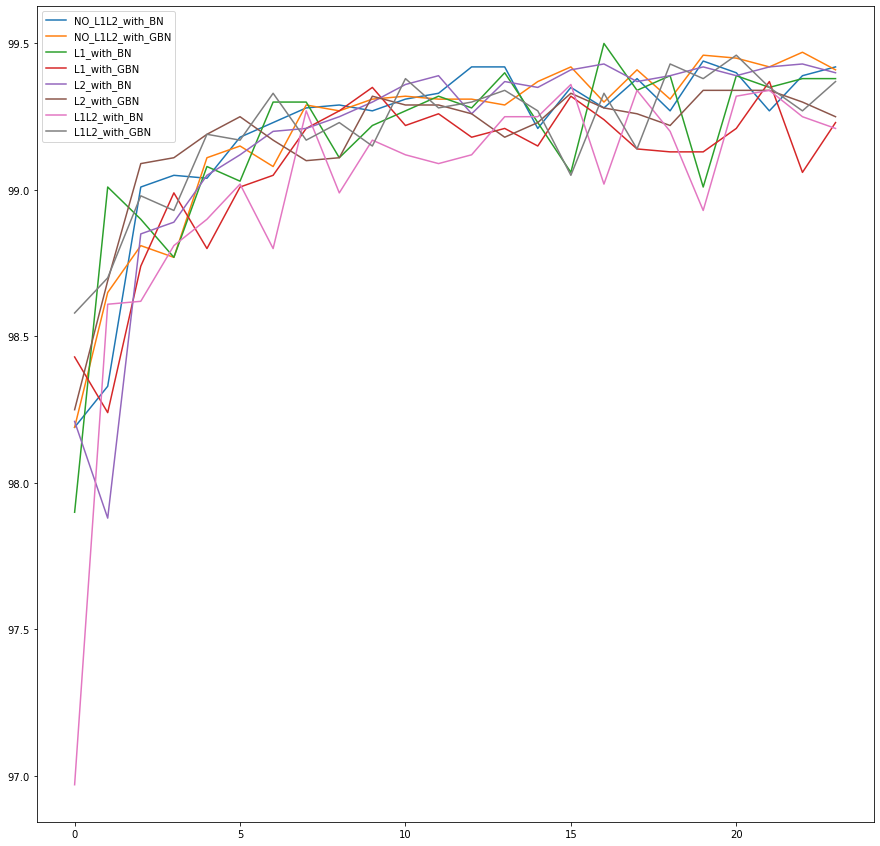

In [21]:
df_accuracy.plot.line(figsize=(15,15))

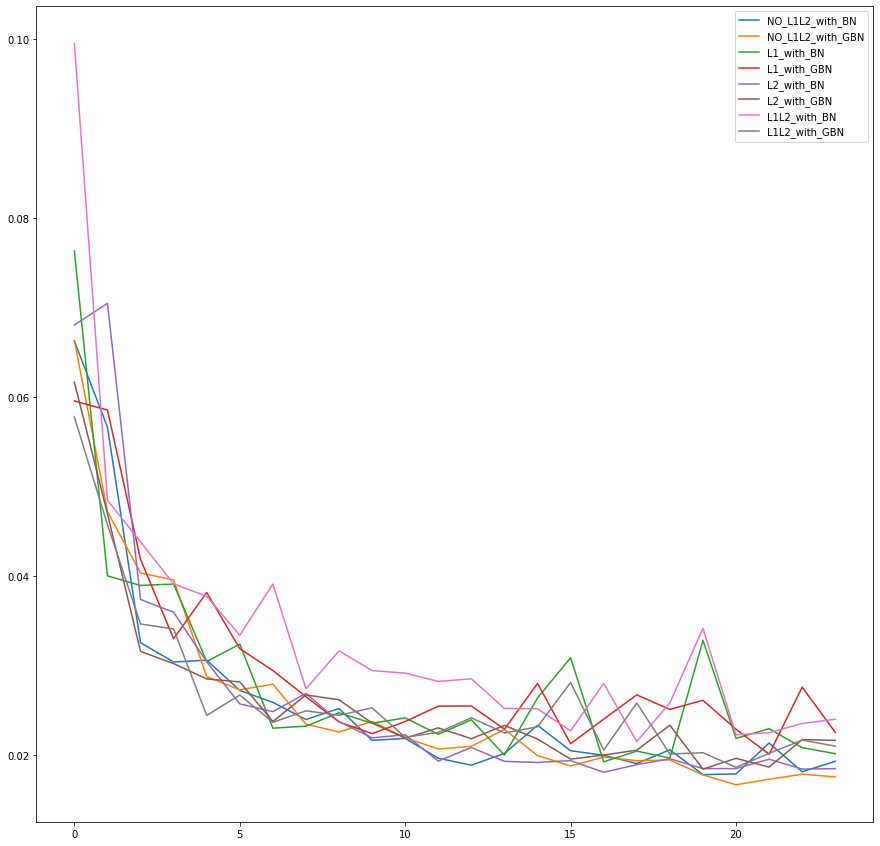

In [22]:
df_loss.plot.line(figsize=(15,15))

In [0]:
def find_misclassified_items(model, test_loader,max_display):
  display_count = 0
  for data, target in test_loader:
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      i = 0
      for i in range(len(pred)):
        if pred[i] != target[i] :
          image = np.squeeze(data[i].numpy())
          image = (image - np.min(image)) / (np.max(image) - np.min(image))
          plt.figure()
          plt.imshow(image,cmap='gray')
          plt.title("Actual :{}; Predicted : {}".format((target[i].detach().numpy()), (pred[i].detach().numpy()[0])))
          display_count += 1 
        i += 1
      if display_count >= max_display:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


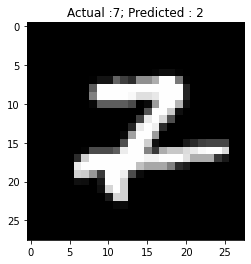

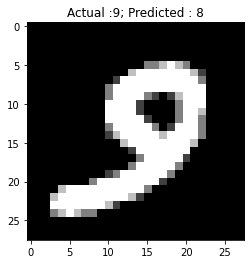

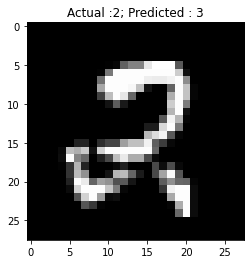

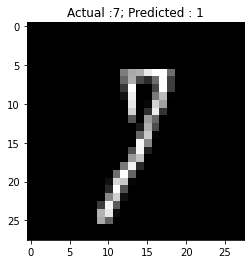

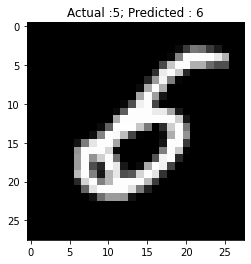

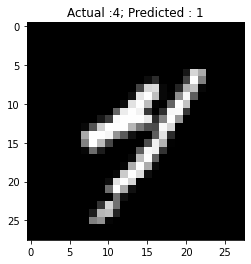

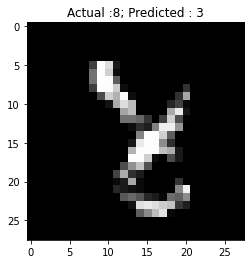

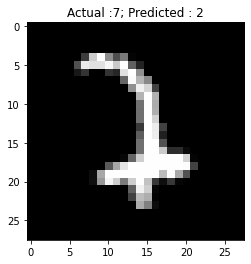

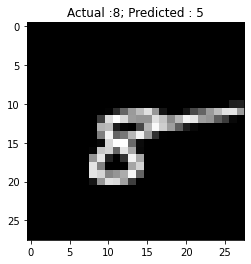

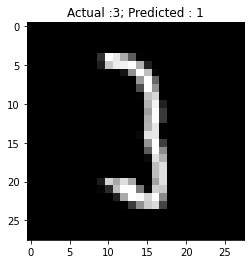

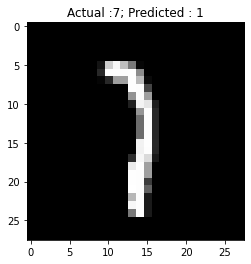

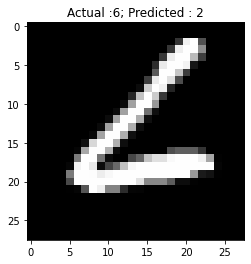

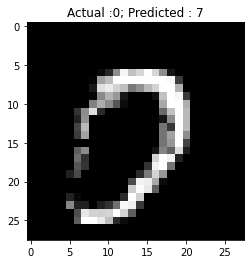

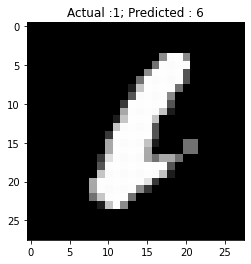

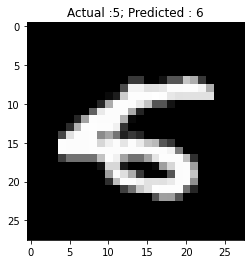

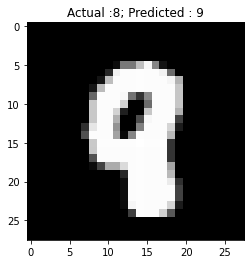

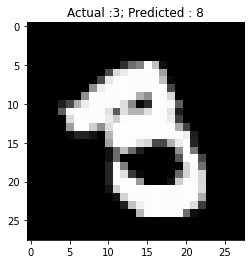

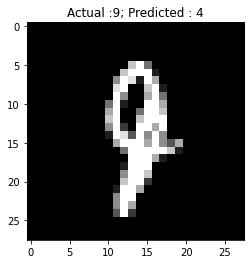

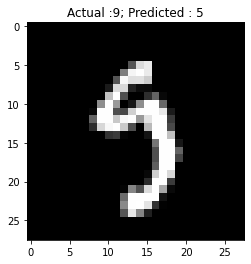

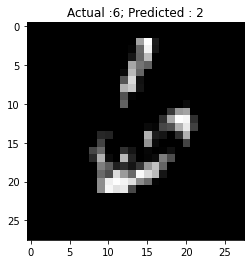

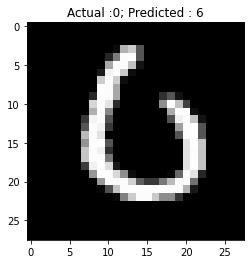

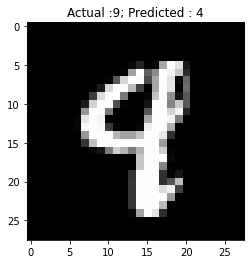

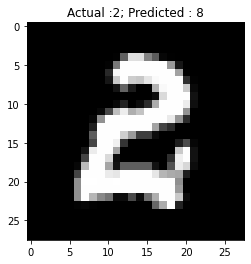

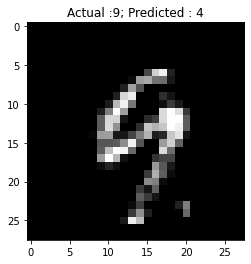

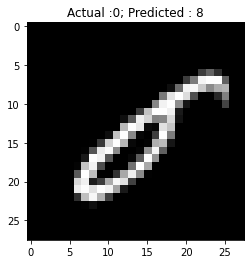

In [14]:
# find any 25 misclassified images for "without L1/L2 with BN" 
model = Net()
model.load_state_dict(torch.load("NO_L1L2_with_BN"))
find_misclassified_items(model=model,test_loader=test_loader,max_display=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


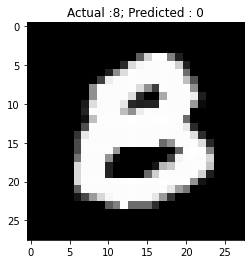

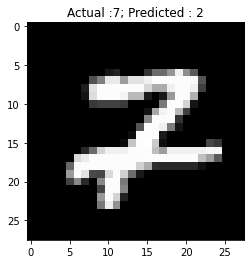

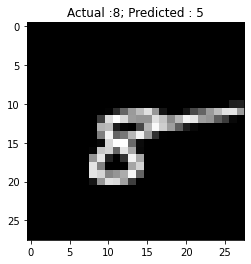

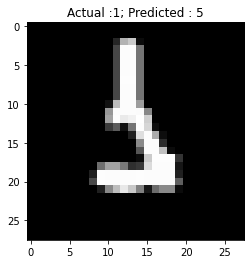

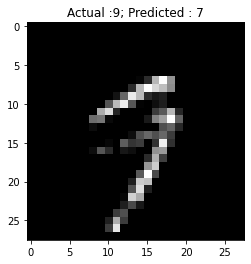

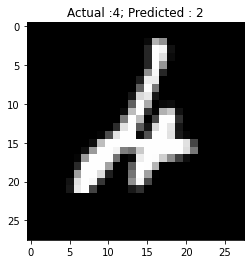

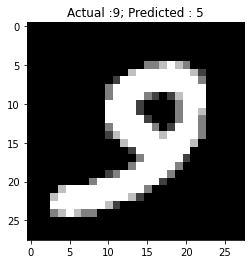

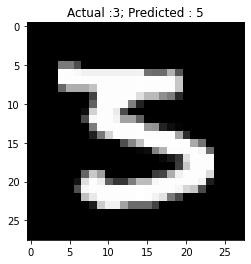

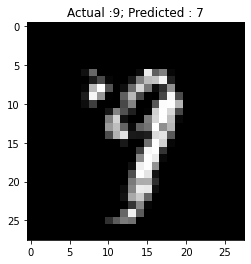

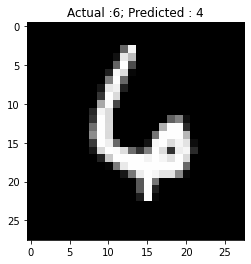

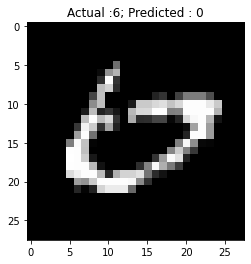

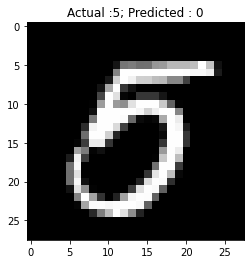

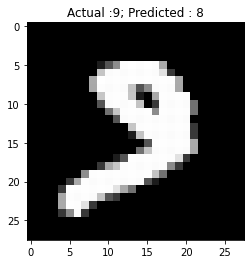

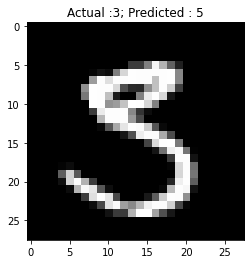

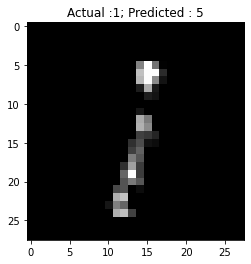

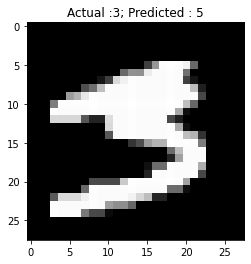

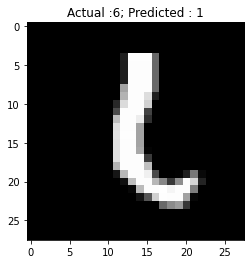

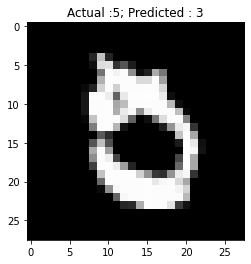

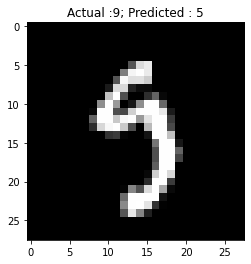

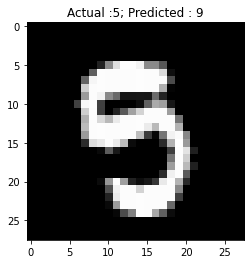

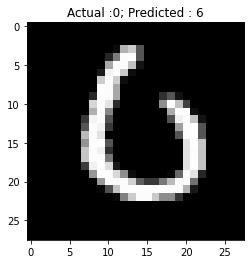

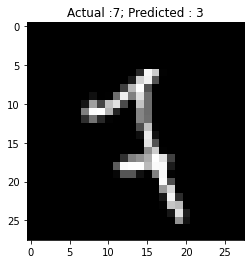

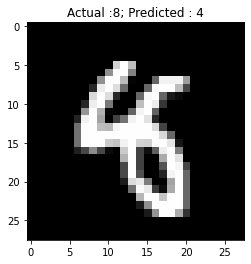

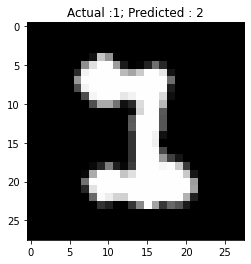

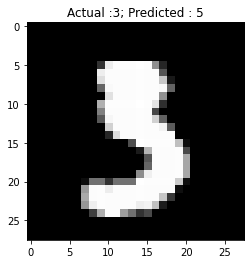

In [17]:
# find any 25 misclassified images for "without L1/L2 with GBN" model.
model = NetGBN()
model.load_state_dict(torch.load("NO_L1L2_with_GBN"))
find_misclassified_items(model=model,test_loader=test_loader,max_display=25)